In [1]:
from fullfrlm import flow_refueling_location_model
from generate_network import generate_network
from flow_computation import flow_computation
from random_vessel_generator import random_vessel_generator
from first_stage_frlm import first_stage_frlm
from second_stage_frlm import second_stage_frlm
from create_input_data_abm import create_input_data_abm
from visualize_placement import visualize_placement
import pickle
import time


## Load necessary data

In [2]:
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/revised_cleaning_results/ivs_exploded_100.p", "rb"))
path_lengths = pickle.load(open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "rb"))

## Generate random df

In [3]:
%%time
df_chance = df_ivs.copy()
df_random1 = random_vessel_generator(df_chance, 1)

CPU times: total: 172 ms
Wall time: 169 ms



## Compute path flows

In [4]:
%%time
flows = flow_computation(df_random1)

CPU times: total: 469 ms
Wall time: 483 ms


## Generate network

In [5]:
%%time
G = pickle.load(open('data/network_cleaned_final.p', 'rb'))
paths = pickle.load(open("data/final_paths.p", "rb"))
G, paths, inserted_nodes = generate_network(G, paths, 20)

CPU times: total: 531 ms
Wall time: 529 ms


In [6]:
%%time
# range r in meters
df_b, df_g, df_eq_fq, feasible_combinations = first_stage_frlm(100000, G, OD=flows, paths=paths, path_lengths=path_lengths, df_h=df_h, additional_nodes=inserted_nodes)

CPU times: total: 1.22 s
Wall time: 1.22 s


## Run second stage FRLM

In [7]:
%%time
optimal_facilities, optimal_flows, non_zero_flows, supported_flow, routes_supported = second_stage_frlm(100, 10, 5, df_g, df_b, df_eq_fq)

Optimal
CPU times: total: 15.3 s
Wall time: 19.6 s


In [8]:
sum(optimal_facilities.values())

100.0

In [9]:
sum(optimal_flows.values())

58.49505388852

In [10]:
supported_flow

523.4161095636516

## Create input data ABM

In [11]:
%%time
df_abm = create_input_data_abm(G,paths, non_zero_flows, optimal_facilities)

CPU times: total: 46.9 ms
Wall time: 45.3 ms


In [12]:
df_abm

,source,target,length_m,X,Y,node_id,charging_stations,model_type
0,30986055,8867600,8380.518917,NaN,NaN,NaN,NaN,link
1,30986055,8864167,68.700608,NaN,NaN,NaN,NaN,link
2,30986055,8865756,2481.139176,NaN,NaN,NaN,NaN,link
3,11309058,8865990,18936.187403,NaN,NaN,NaN,NaN,link
4,11309058,8866775,11560.215727,NaN,NaN,NaN,NaN,link
...,...,...,...,...,...,...,...,...
138,NaN,NaN,NaN,5.279431,52.310390,111,1.0,inserted_node
139,NaN,NaN,NaN,4.436741,51.676455,112,3.0,inserted_node
140,NaN,NaN,NaN,5.210375,53.241520,113,5.0,inserted_node
141,NaN,NaN,NaN,5.700503,51.787230,115,0.0,inserted_node


## Visualize placement

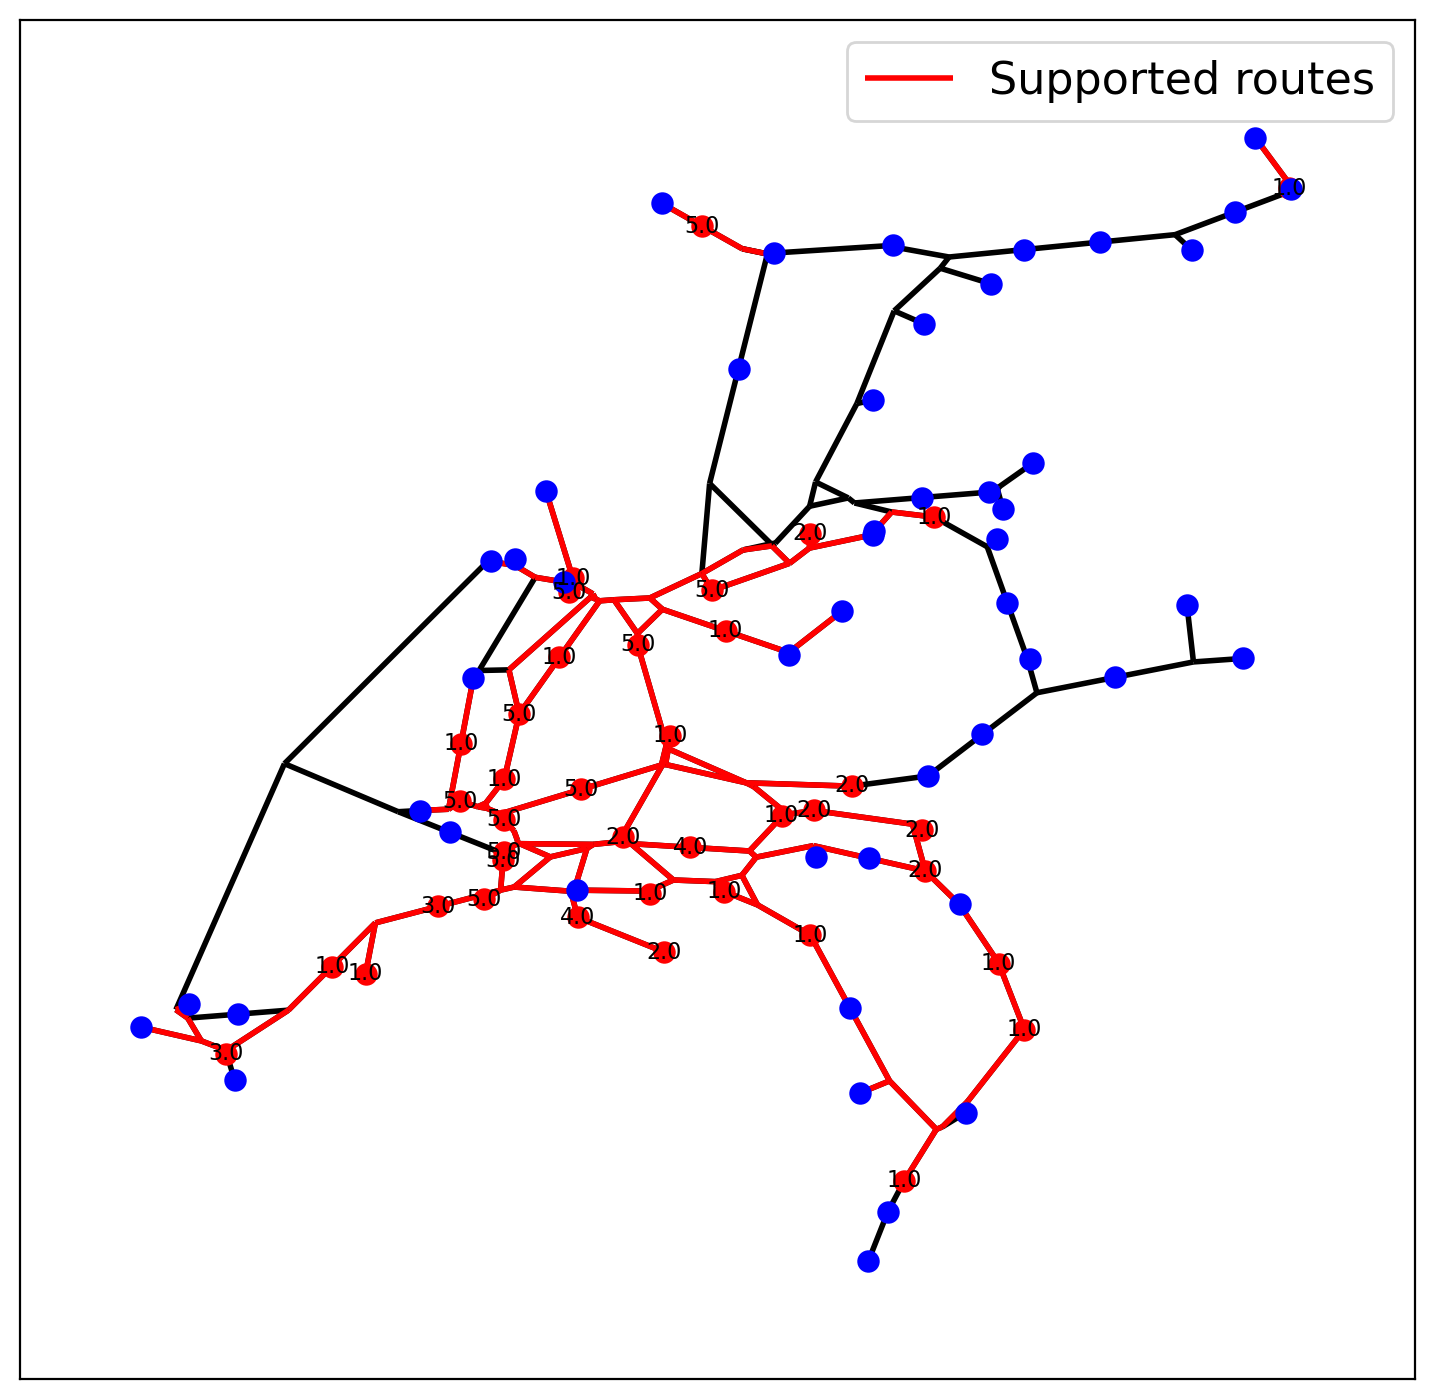

CPU times: total: 406 ms
Wall time: 478 ms


In [13]:
%%time
visualize_placement(G, flows, optimal_facilities, non_zero_flows, df_h, paths, unused=True)

## Try out complete function

### range 50km

Optimal


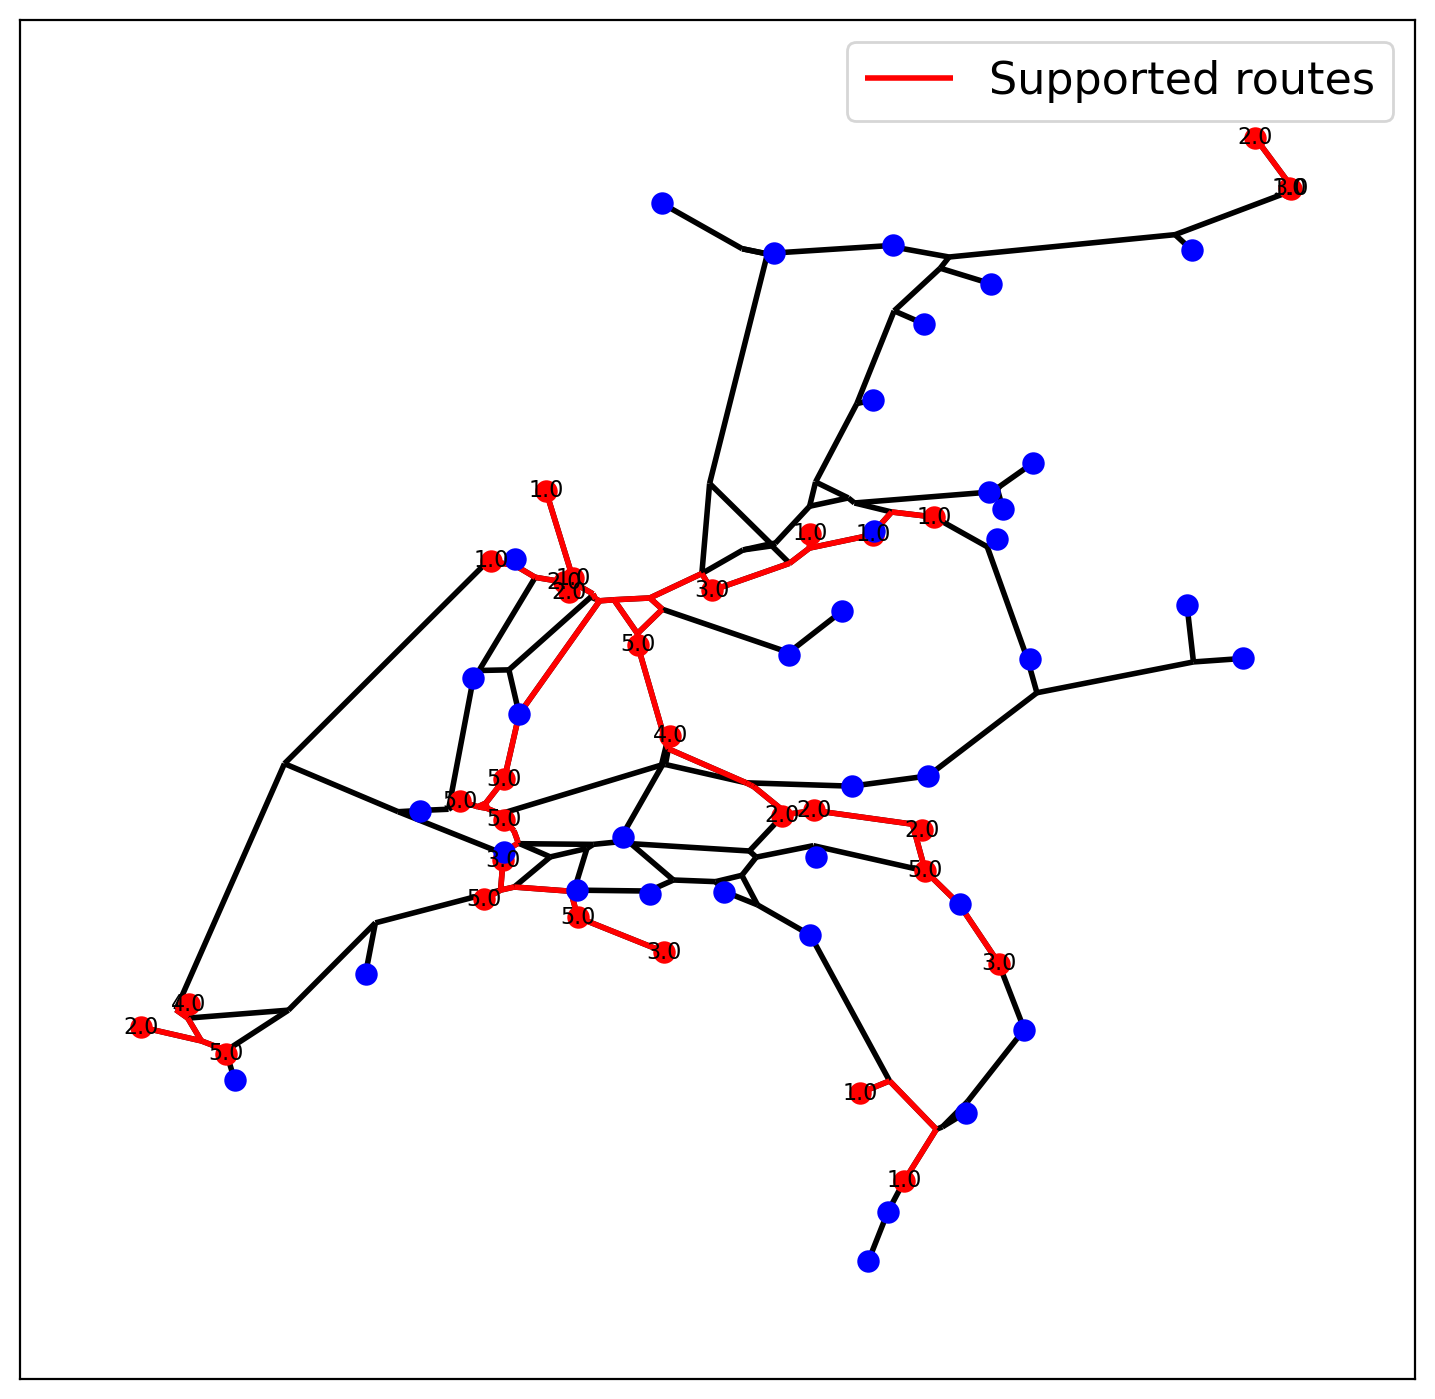

(1257.3618003913894,
 0.15436626650928026,
 0.26472332309248503,
 0.5831230308912,
 {'22637863': 0.0,
  '22638146': 2.0,
  '22638156': 0.0,
  '22638320': 0.0,
  '22638327': 2.0,
  '30984595': 5.0,
  '8861305': 0.0,
  '8861462': 0.0,
  '8861528': 2.0,
  '8861625': 1.0,
  '8861718': 0.0,
  '8862085': 0.0,
  '8862497': 1.0,
  '8862506': 0.0,
  '8862570': 0.0,
  '8862663': 3.0,
  '8863019': 0.0,
  '8863125': 0.0,
  '8863152': 0.0,
  '8863207': 0.0,
  '8863260': 2.0,
  '8863306': 5.0,
  '8863360': 0.0,
  '8863408': 0.0,
  '8863469': 5.0,
  '8863518': 0.0,
  '8863614': 1.0,
  '8863709': 1.0,
  '8863818': 5.0,
  '8863861': 0.0,
  '8863966': 0.0,
  '8864005': 3.0,
  '8864018': 0.0,
  '8864111': 4.0,
  '8864153': 0.0,
  '8864494': 0.0,
  '8864566': 3.0,
  '8864837': 5.0,
  '8864954': 0.0,
  '8865003': 0.0,
  '8865412': 2.0,
  '8865600': 5.0,
  '8865605': 0.0,
  '8865756': 0.0,
  '8865990': 0.0,
  '8866297': 2.0,
  '8866425': 0.0,
  '8866564': 0.0,
  '8866627': 0.0,
  '8866671': 0.0,
  '8866686'

In [14]:
flow_refueling_location_model(1, 50000, 100, 5, 5, vis=True)

Optimal


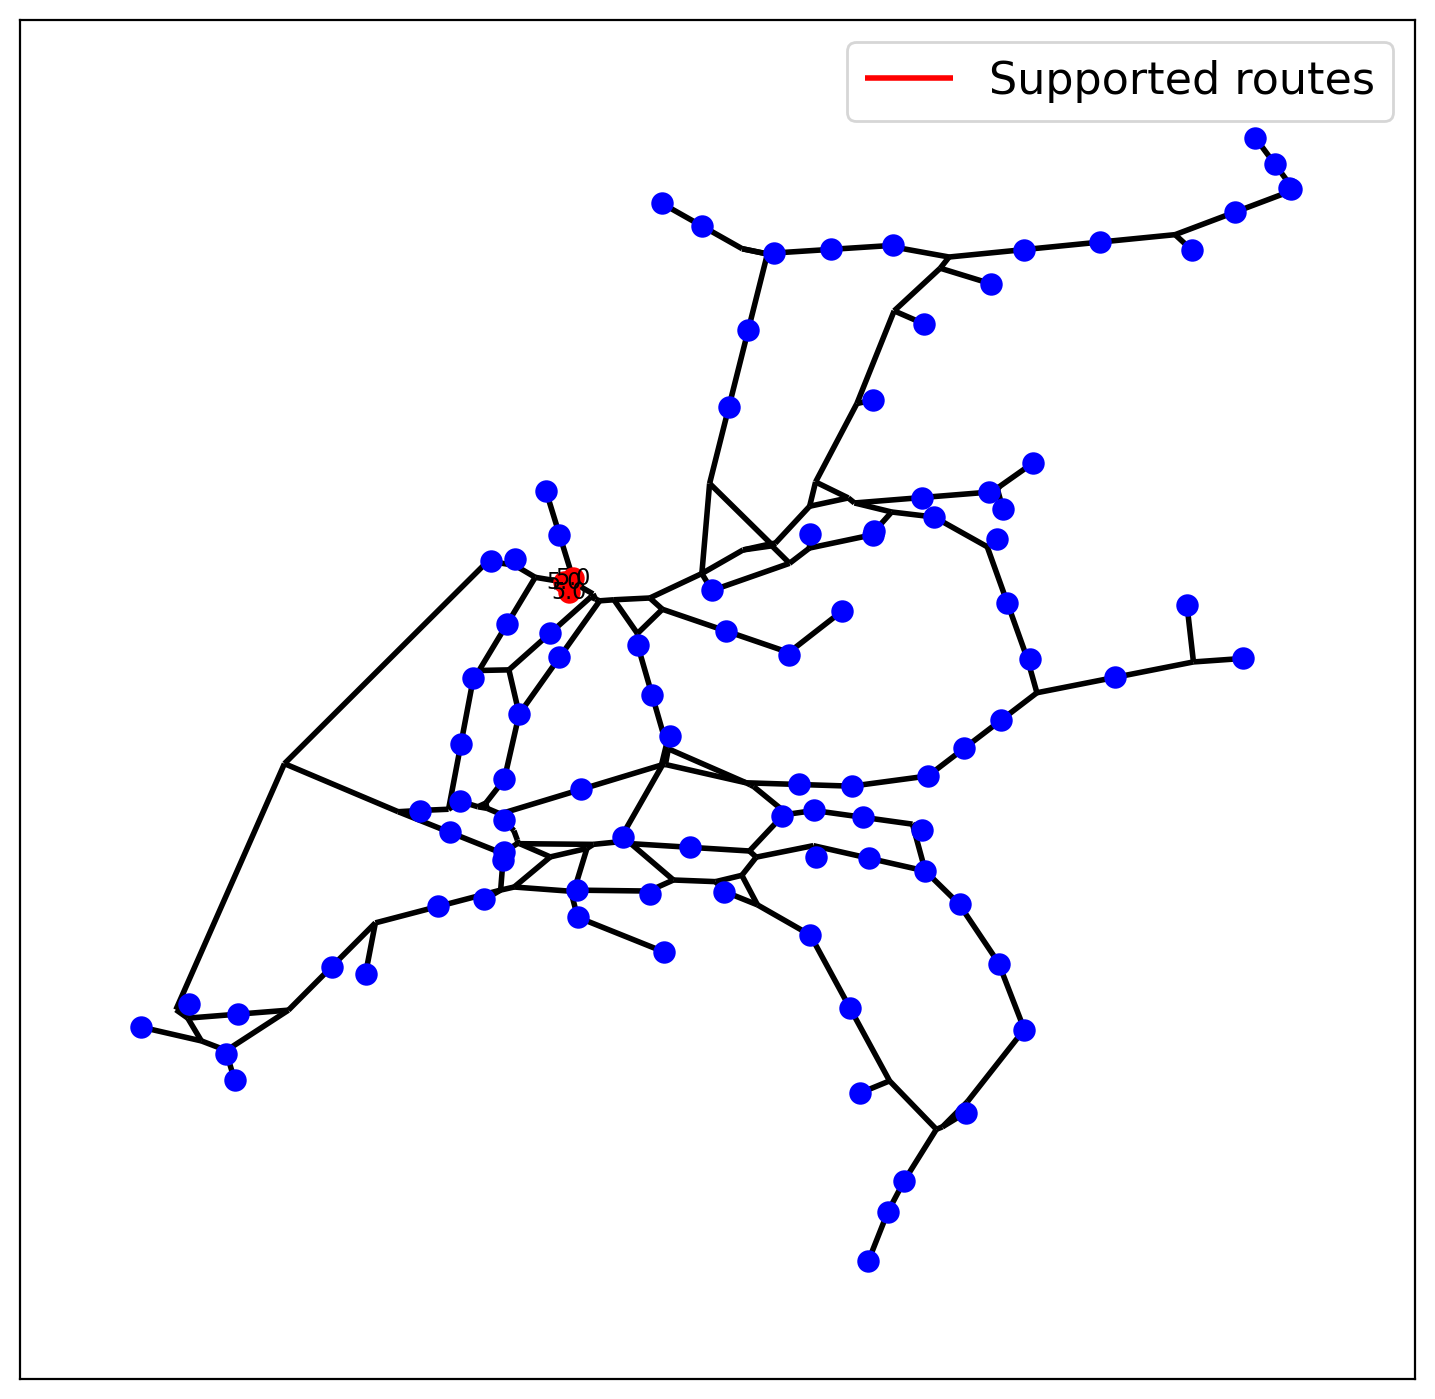

In [15]:
total_flow, fraction_captured_total, serveable_fraction, served_fraction, optimal_facilities, non_zero_flows, routes_supported, paths, G, df_abm, flows = flow_refueling_location_model(1, 10000, 100, 5, 5, 30, vis=True)

### range 100km

Optimal


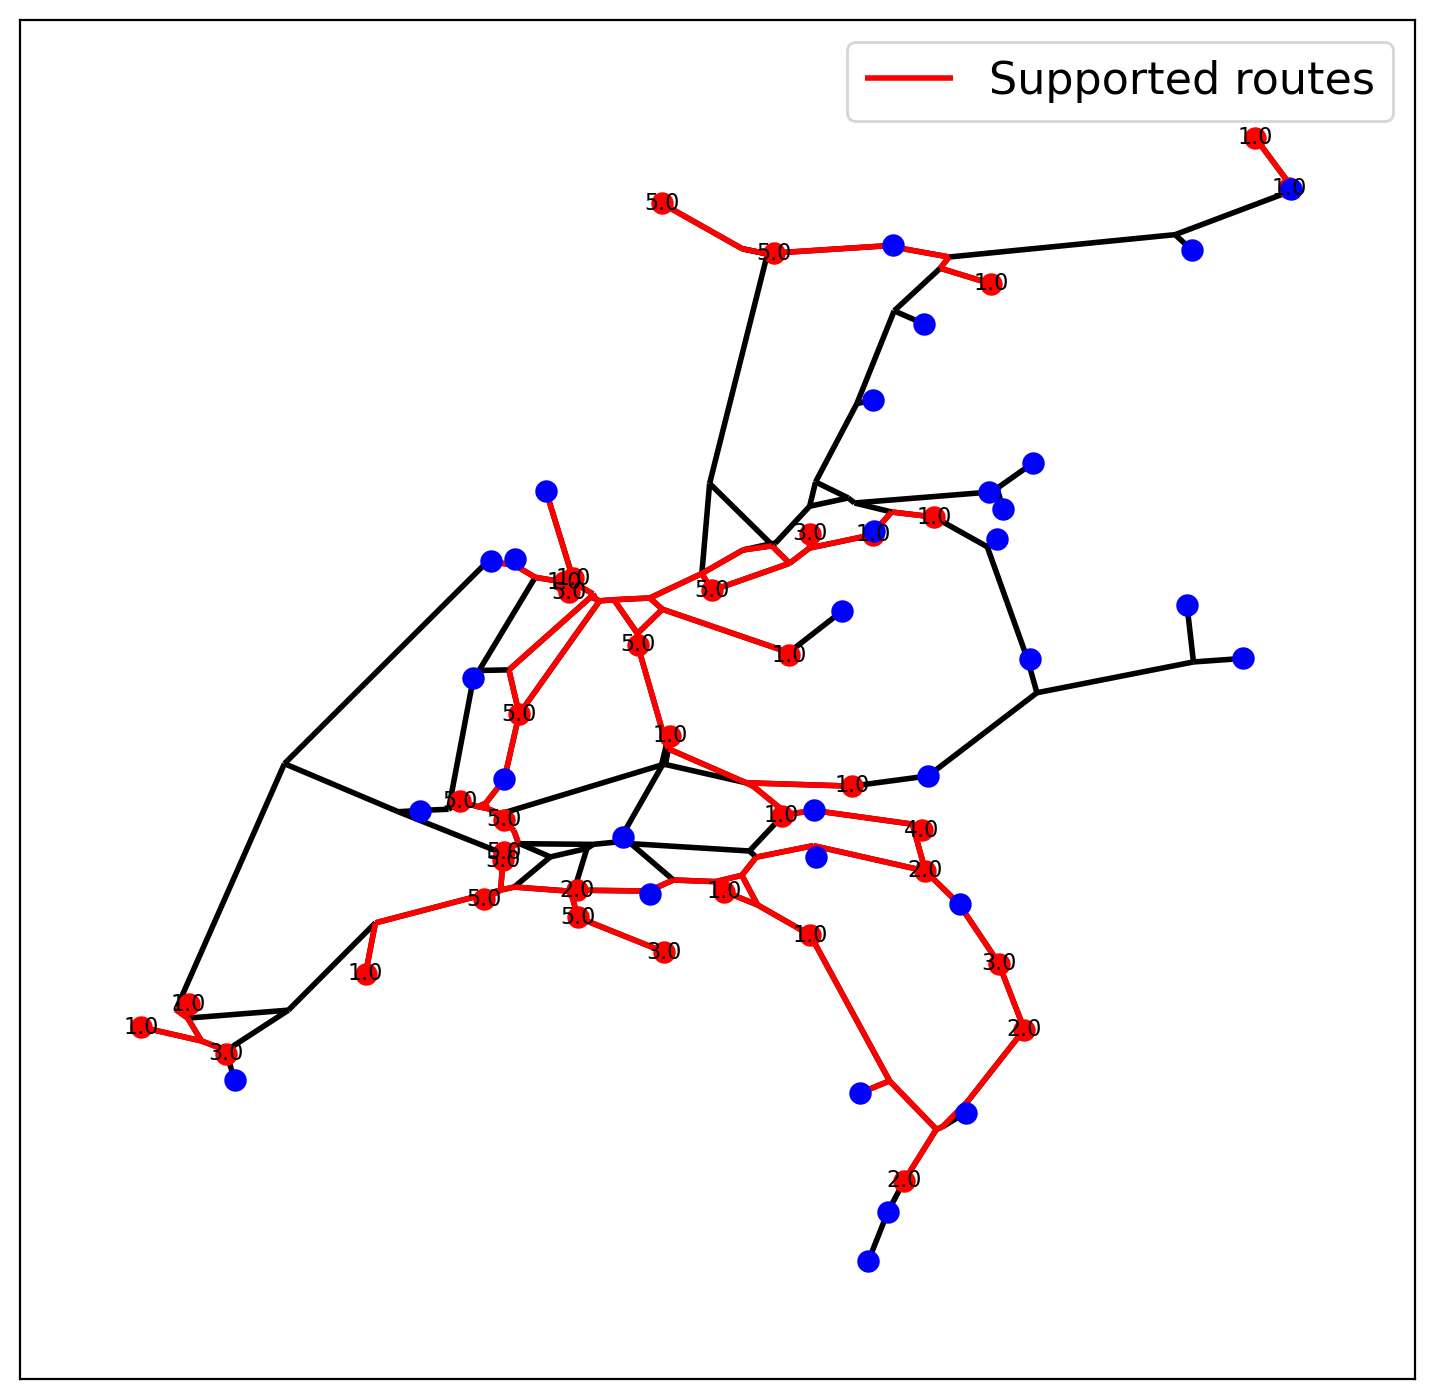

(1258.894481409002,
 0.27399678769508534,
 0.44508059971483055,
 0.6156116170209148,
 {'22637863': 2.0,
  '22638146': 1.0,
  '22638156': 0.0,
  '22638320': 0.0,
  '22638327': 4.0,
  '30984595': 5.0,
  '8861305': 0.0,
  '8861462': 0.0,
  '8861528': 1.0,
  '8861625': 0.0,
  '8861718': 0.0,
  '8862085': 0.0,
  '8862497': 0.0,
  '8862506': 0.0,
  '8862570': 0.0,
  '8862663': 5.0,
  '8863019': 0.0,
  '8863125': 0.0,
  '8863152': 0.0,
  '8863207': 0.0,
  '8863260': 1.0,
  '8863306': 5.0,
  '8863360': 5.0,
  '8863408': 0.0,
  '8863469': 3.0,
  '8863518': 1.0,
  '8863614': 1.0,
  '8863709': 3.0,
  '8863818': 5.0,
  '8863861': 0.0,
  '8863966': 0.0,
  '8864005': 5.0,
  '8864018': 0.0,
  '8864111': 1.0,
  '8864153': 0.0,
  '8864494': 1.0,
  '8864566': 3.0,
  '8864837': 5.0,
  '8864954': 0.0,
  '8865003': 5.0,
  '8865412': 0.0,
  '8865600': 2.0,
  '8865605': 5.0,
  '8865756': 5.0,
  '8865990': 1.0,
  '8866297': 1.0,
  '8866425': 0.0,
  '8866564': 0.0,
  '8866627': 0.0,
  '8866671': 0.0,
  '886668

In [16]:
flow_refueling_location_model(1, 100000, 100, 5, 5, vis=True)


Optimal


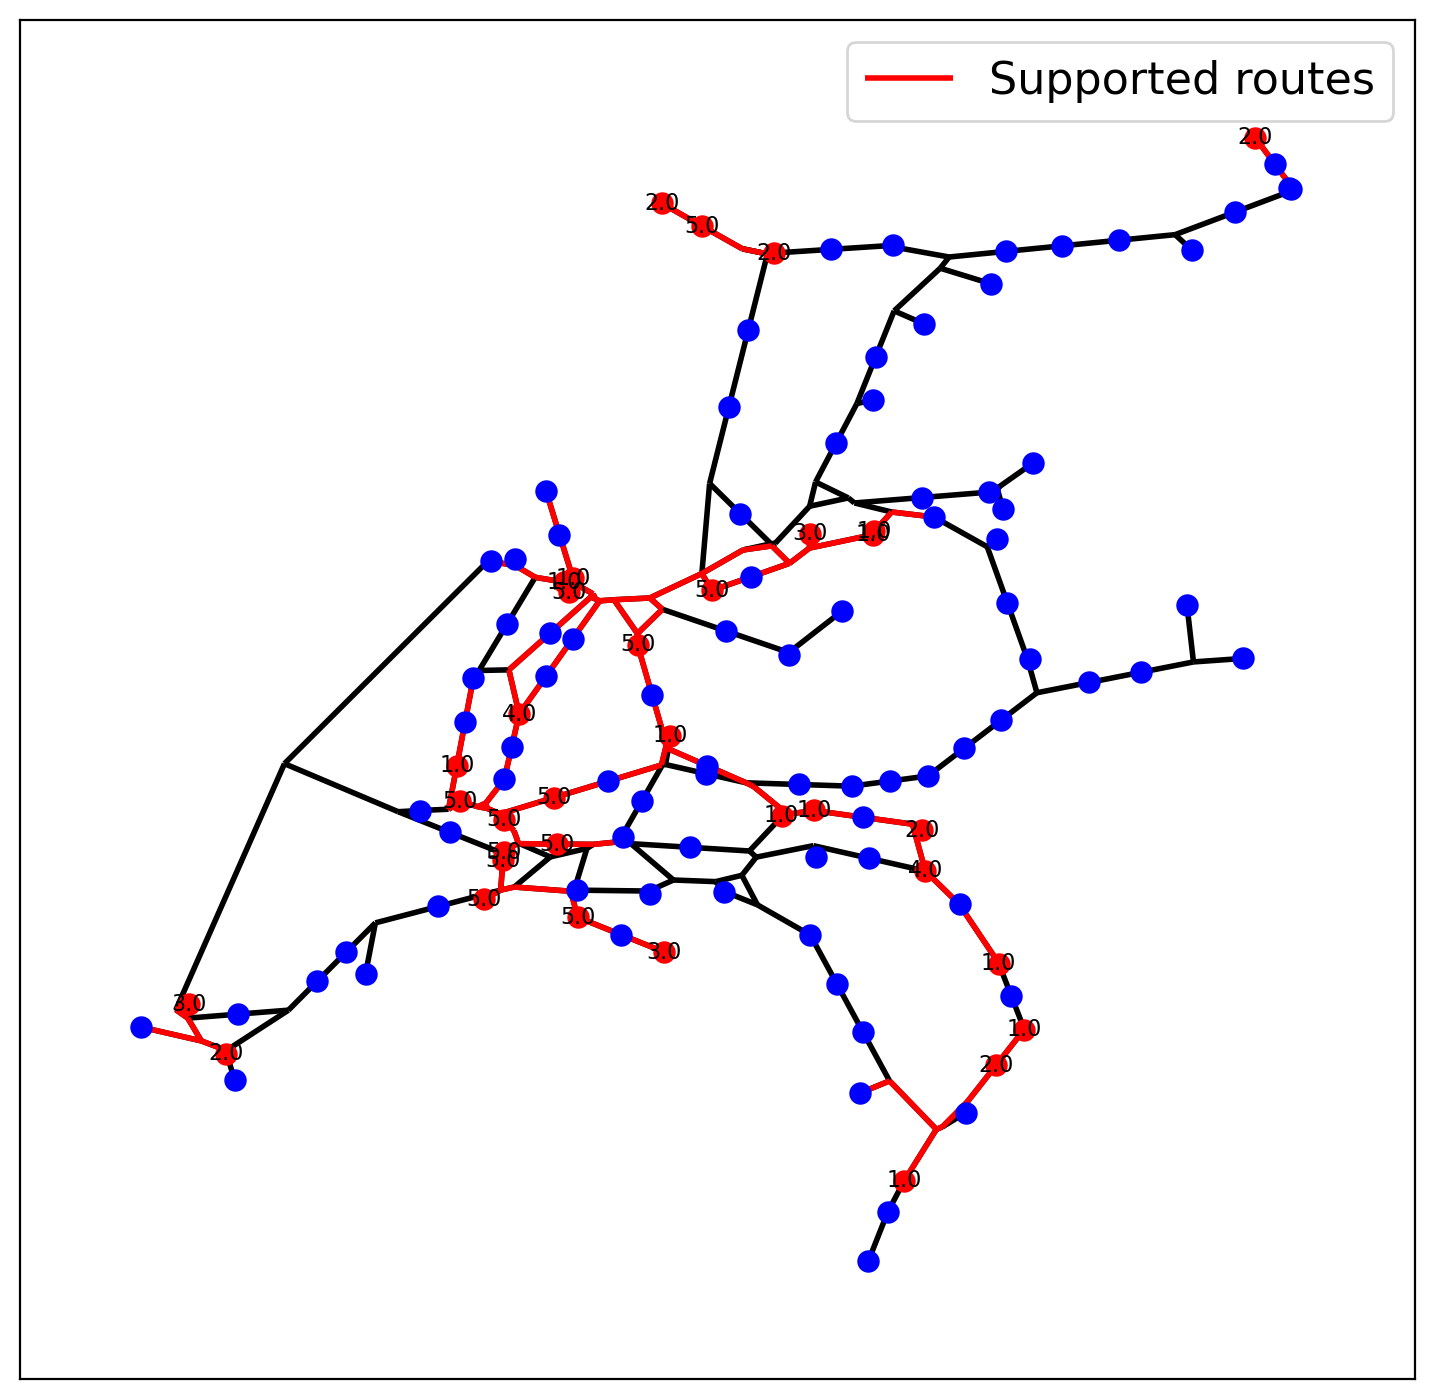

(1256.8089236790609,
 0.28511419815937067,
 0.8347144390907324,
 0.34157094307599384,
 {'109': 0.0,
  '110': 0.0,
  '111': 0.0,
  '112': 0.0,
  '113': 5.0,
  '114': 0.0,
  '115': 0.0,
  '116': 0.0,
  '119': 0.0,
  '120': 0.0,
  '121': 0.0,
  '122': 0.0,
  '123': 0.0,
  '124': 0.0,
  '125': 0.0,
  '126': 0.0,
  '127': 0.0,
  '128': 0.0,
  '129': 0.0,
  '130': 0.0,
  '131': 0.0,
  '132': 0.0,
  '133': 0.0,
  '134': 2.0,
  '135': 0.0,
  '136': 0.0,
  '137': 0.0,
  '138': 0.0,
  '139': 5.0,
  '140': 0.0,
  '141': 0.0,
  '142': 1.0,
  '143': 0.0,
  '144': 0.0,
  '145': 0.0,
  '146': 0.0,
  '147': 0.0,
  '148': 0.0,
  '149': 0.0,
  '150': 0.0,
  '151': 0.0,
  '152': 0.0,
  '153': 0.0,
  '154': 0.0,
  '155': 0.0,
  '156': 0.0,
  '157': 0.0,
  '158': 0.0,
  '159': 0.0,
  '160': 5.0,
  '22637863': 1.0,
  '22638146': 1.0,
  '22638156': 0.0,
  '22638320': 0.0,
  '22638327': 2.0,
  '30984595': 5.0,
  '8861305': 0.0,
  '8861462': 0.0,
  '8861528': 0.0,
  '8861625': 0.0,
  '8861718': 0.0,
  '8862085

In [17]:
flow_refueling_location_model(1, 100000, 100, 5, 5, 50, vis=True)